## Building a  forecasting model

In [ ]:
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout    

2025-08-11 17:18:24.861387: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-11 17:18:26.138351: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv

In [ ]:
tsla = pd.read_csv("../data/processed/combined_processed.csv")

In [11]:
tsla['Date'] = pd.to_datetime(tsla['Date'], format="mixed")

In [7]:
tsla_return = tsla['daily_percentage']
train_len = 0.8 # 80%
train_size = int(len(tsla_return)*train_len)
train_data, test_data = tsla_return[0:train_size], tsla_return[train_size:len(tsla_return)]
train_arima = train_data.values
test_arima = test_data.values
arima_order = (5, 1, 1)
model_arima = ARIMA(train_arima, order=arima_order)
model_arima_fit = model_arima.fit()
print("ARIMA model trained.")
print(model_arima_fit.summary()) # Print model summary for details

ARIMA model trained.
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1876
Model:                 ARIMA(5, 1, 1)   Log Likelihood                3506.091
Date:                Mon, 11 Aug 2025   AIC                          -6998.182
Time:                        18:08:24   BIC                          -6959.427
Sample:                             0   HQIC                         -6983.905
                               - 1876                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0034      0.019      0.173      0.863      -0.035       0.041
ar.L2          0.0772      0.016      4.693      0.000       0.045       0.109
ar.L3         -0.0200      0.01

/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Making predictions with ARIMA model...


/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mikiask/anotherproject/Time-Series-Forecasting-fo

ARIMA RMSE: 0.0400


NameError: name 'ticker' is not defined

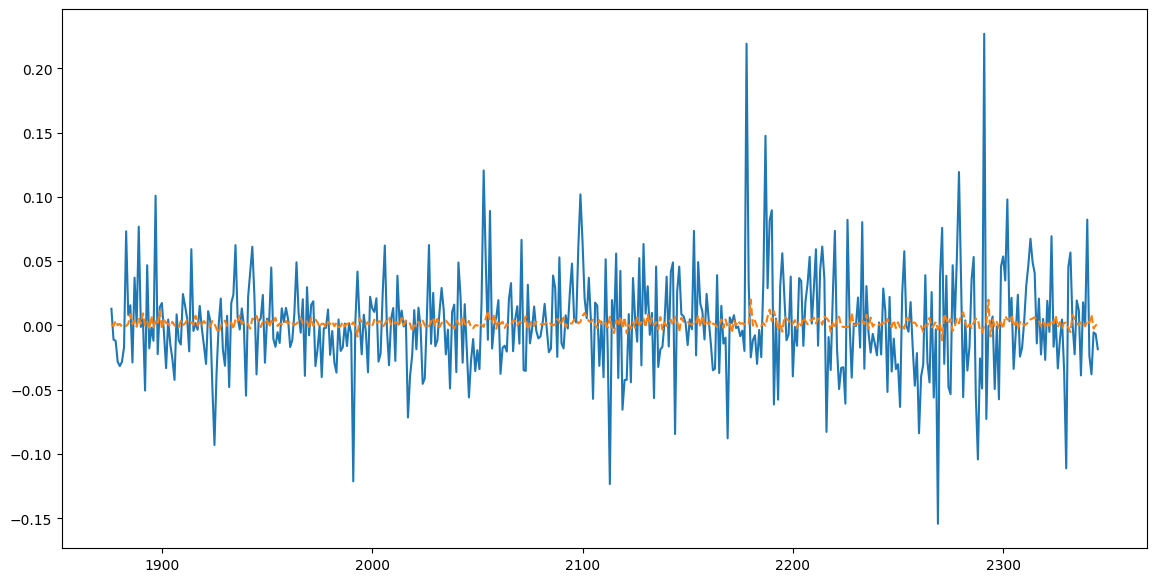

In [ ]:
history_arima = [x for x in train_arima]
predictions_arima = []

print("\nMaking predictions with ARIMA model...")
for t in range(len(test_arima)):
    model = ARIMA(history_arima, order=arima_order)
    model_fit = model.fit()
    output = model_fit.forecast() # Forecast the next value
    yhat = output[0]
    predictions_arima.append(yhat)
    obs = test_arima[t]
    history_arima.append(obs) # Add actual observation to history for next prediction

# Evaluate ARIMA performance
rmse_arima = np.sqrt(mean_squared_error(test_arima, predictions_arima))
print(f'ARIMA RMSE: {rmse_arima:.4f}')

# Plot ARIMA predictions vs. actual


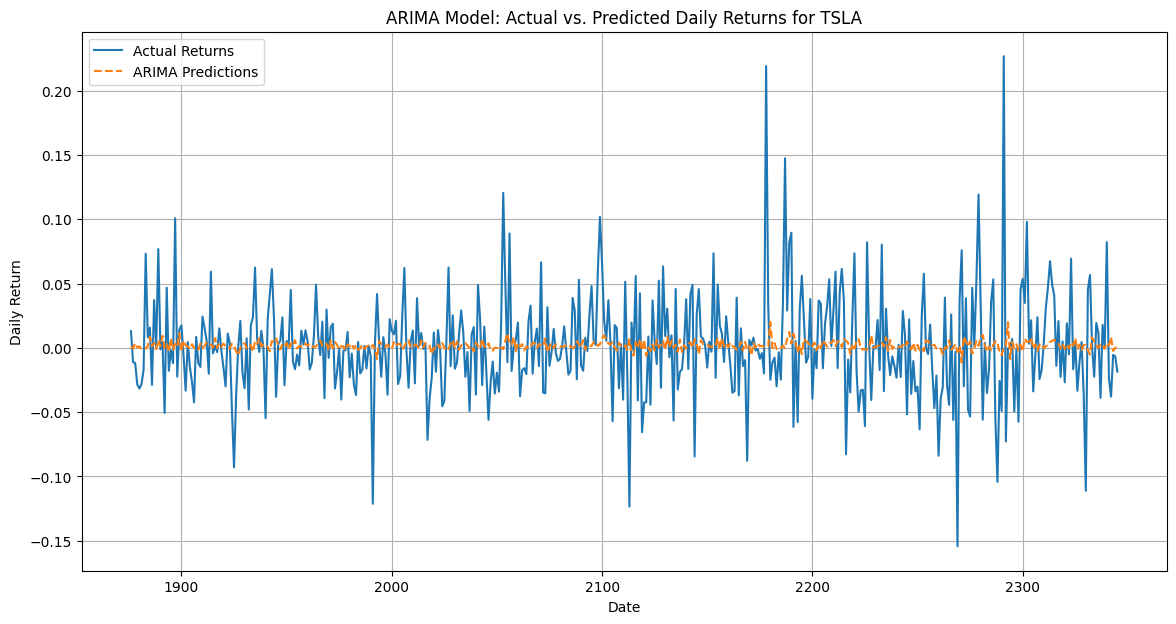

In [15]:
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, test_data.values, label='Actual Returns')
plt.plot(test_data.index, predictions_arima, label='ARIMA Predictions', linestyle='--')
plt.title(f'ARIMA Model: Actual vs. Predicted Daily Returns for TSLA')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
def create_sequences_lstm(data, time_step):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0] # features for time_step
        X.append(a)
        Y.append(data[i + time_step, 0]) # target value
    return np.array(X), np.array(Y)

time_step = 60

In [13]:
scale = MinMaxScaler(feature_range=(0,1))
scaled_data = scale.fit_transform(tsla_return.values.reshape(-1,1))

train_scaled = scaled_data[0:train_size, :]
test_scaled = scaled_data[train_size:len(tsla_return),:]

X_train, y_train = create_sequences_lstm(train_scaled, time_step)
X_test, y_test = create_sequences_lstm(test_scaled, time_step)


LSTM X_train shape: (1815, 60)
LSTM X_test shape: (409, 60)

Building LSTM model...


/home/mikiask/anotherproject/Time-Series-Forecasting-for-Portfolio-Management-Optimization-week10/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training LSTM model...
Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - loss: 0.0123
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0058
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.0057
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.0057
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 0.0057
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0053
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.0056
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0054
Epoch 9/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0055
Epoch 10/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0054
Epoch 11/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.0054
Epoch 12/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0053
Epoch 13/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0053
Epoch 14/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0052
Epoch 15/100
57/57 ━━━━━━━━━━━━

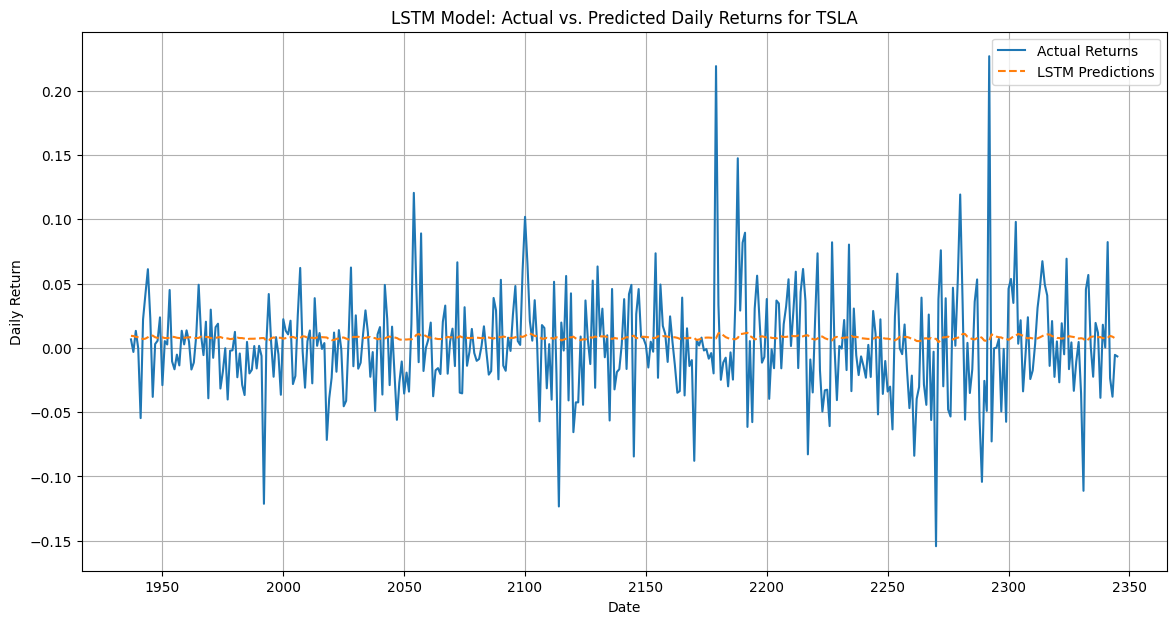

In [15]:
print(f"\nLSTM X_train shape: {X_train.shape}")
print(f"LSTM X_test shape: {X_test.shape}")

# Build the LSTM model
print("\nBuilding LSTM model...")
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1))) # First LSTM layer
model_lstm.add(Dropout(0.2)) # Dropout for regularization
model_lstm.add(LSTM(units=50, return_sequences=False)) # Second LSTM layer
model_lstm.add(Dropout(0.2)) # Another dropout layer
model_lstm.add(Dense(units=1)) # Output layer for single prediction

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

print("Training LSTM model...")
# Fit the model
# Using verbose=1 to see training progress
model_lstm.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

print("LSTM model trained.")

# Make predictions
print("\nMaking predictions with LSTM model...")
predictions_lstm_scaled = model_lstm.predict(X_test)

# Inverse transform the predictions to original scale
predictions_lstm = scale.inverse_transform(predictions_lstm_scaled)

# Inverse transform y_test to original scale for comparison
y_test_actual = scale.inverse_transform(y_test.reshape(-1, 1))

# Evaluate LSTM performance
# Ensure y_test_actual and predictions_lstm have the same number of elements
min_len = min(len(y_test_actual), len(predictions_lstm))
rmse_lstm = np.sqrt(mean_squared_error(y_test_actual[:min_len], predictions_lstm[:min_len]))
print(f'LSTM RMSE: {rmse_lstm:.4f}')

# Plot LSTM predictions vs. actual
# Adjust test_data index to match the length of predictions
plot_start_index = len(train_data) + time_step + 1 # Adjust for look-back window
plot_indices = tsla_return.index[plot_start_index : plot_start_index + min_len]


plt.figure(figsize=(14, 7))
plt.plot(plot_indices, y_test_actual[:min_len], label='Actual Returns')
plt.plot(plot_indices, predictions_lstm[:min_len], label='LSTM Predictions', linestyle='--')
plt.title(f'LSTM Model: Actual vs. Predicted Daily Returns for TSLA')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Assuming 'train_data' and 'test_data' are prepared as in your Canvas
# Convert to numpy arrays if not already
train_arima = train_data.values
test_arima = test_data.values
    
# Define the p, d, q ranges to search
p_values = range(0, 3) # Example: 0, 1, 2
d_values = [0]        # d is 0 for stationary daily returns
q_values = range(0, 3) # Example: 0, 1, 2

best_rmse = float('inf')
best_order = None

print("Starting Grid Search for ARIMA parameters...")

# Suppress warnings during the grid search for cleaner output
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

    for p in p_values:
        for d in d_values: # d will likely be 0 for daily returns
            for q in q_values:
                order = (p, d, q)
                try:
                    # Fit model
                    model = ARIMA(train_arima, order=order)
                    model_fit = model.fit(maxiter=500) # Increase maxiter to aid convergence

                    # Make predictions (simple one-step ahead forecasting)
                    history = [x for x in train_arima]
                    predictions = []
                    for t in range(len(test_arima)):
                        model = ARIMA(history, order=order)
                        model_fit = model.fit(maxiter=500) # Need to fit repeatedly for walk-forward
                        yhat = model_fit.forecast()[0]
                        predictions.append(yhat)
                        history.append(test_arima[t])

                    # Evaluate performance
                    rmse = np.sqrt(mean_squared_error(test_arima, predictions))

                    # Update best model if current one is better
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_order = order
                    print(f'ARIMA{order} RMSE: {rmse:.4f}')

                except Exception as e:
                    # print(f'ARIMA{order} failed: {e}') # Uncomment to see specific errors
                    continue # Skip to the next combination if fitting fails

print(f"\nGrid Search Complete. Best ARIMA Order: {best_order} with RMSE: {best_rmse:.4f}")

Starting Grid Search for ARIMA parameters...


NameError: name 'warnings' is not defined